# 10-Armed Bandit Problem

This notebook implements a solution to the classic 10-Armed Bandit problem using epsilon-greedy strategies. We compare three agents:
- **Greedy**: Always exploits the best known action (ε=0)
- **ε=0.1**: Explores 10% of the time
- **ε=0.01**: Explores 1% of the time

The results show how exploration affects short-term and long-term rewards.

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

## Testbed Class

The Testbed represents the environment with 10 arms. Each arm has a true action value drawn from a normal distribution. The agent must learn these values through interaction.

In [2]:
class Testbed(object):
    """
    Testbed class containing the states, actions, and rules of the bandit environment.
    Each arm has a true action value from which rewards are sampled.
    """

    def __init__(self, nArms, mean, stDev):
        """
        Initialize the Testbed with nArms bandits.
        
        Args:
            nArms: Number of arms (bandits)
            mean: Mean for the normal distribution of true action values
            stDev: Standard deviation for the normal distribution
        """
        self.nArms = nArms
        self.mean = mean
        self.stDev = stDev
        self.actArr = np.zeros(nArms)
        self.optim = 0
        self.reset()

    def reset(self):
        """Reset testbed for next iteration by sampling new true action values."""
        # Set random gaussian/normal values for each arm
        self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)
        # Identify the optimal (maximum) action
        self.optim = np.argmax(self.actArr)

## Agent Class

The Agent implements the epsilon-greedy policy. It maintains estimates of action values and uses these to decide whether to explore or exploit.

In [3]:
class Agent(object):
    """
    Agent class implementing epsilon-greedy policy.
    Maintains action value estimates and decides exploration vs exploitation.
    """

    def __init__(self, nArms, eProb=0):
        """
        Initialize the Agent.
        
        Args:
            nArms: Number of arms available
            eProb: Epsilon probability for exploration (0 = greedy, >0 = explore with probability eProb)
        """
        self.nArms = nArms
        self.eProb = eProb
        self.timeStep = 0
        self.lastAction = None
        self.kAction = np.zeros(nArms)
        self.rSum = np.zeros(nArms)
        self.valEstimates = np.zeros(nArms)

    def __str__(self):
        """Return string representation for graph legend."""
        if self.eProb == 0:
            return "Greedy"
        else:
            return f"ε = {self.eProb}"

    def action(self):
        """
        Select action based on epsilon-greedy policy.
        With probability epsilon, select a random action (explore).
        Otherwise, select the action with the highest estimated value (exploit).
        
        Returns:
            Action index
        """
        randProb = np.random.random()
        
        if randProb < self.eProb:
            # Explore: select random action
            a = np.random.choice(len(self.valEstimates))
        else:
            # Exploit: select action with highest estimated value
            maxVal = np.max(self.valEstimates)
            # Handle ties: if multiple actions have the same max value, choose randomly
            actions = np.where(self.valEstimates == maxVal)[0]
            a = np.random.choice(actions)

        self.lastAction = a
        return a

    def interpreter(self, reward):
        """
        Update action value estimates based on received reward.
        Uses sample-average method: Q(a) = sum(rewards) / count(action_taken)
        
        Args:
            reward: Reward received from the environment
        """
        At = self.lastAction
        self.kAction[At] += 1
        self.rSum[At] += reward
        # Update action-value estimate using sample average
        self.valEstimates[At] = self.rSum[At] / self.kAction[At]
        self.timeStep += 1

    def reset(self):
        """Reset all variables for next iteration."""
        self.timeStep = 0
        self.lastAction = None
        self.kAction[:] = 0
        self.rSum[:] = 0
        self.valEstimates[:] = 0

## Environment Class

The Environment orchestrates the interaction between agents and the testbed, running multiple iterations and plays to collect statistics.

In [4]:
class Environment(object):
    """
    Environment class that orchestrates the interaction between agents and testbed.
    Runs multiple iterations and plays to collect performance statistics.
    """

    def __init__(self, testbed, agents, plays, iterations):
        """
        Initialize the Environment.
        
        Args:
            testbed: Testbed instance representing the bandit environment
            agents: List of Agent instances
            plays: Number of plays (timesteps) per iteration
            iterations: Number of independent runs
        """
        self.testbed = testbed
        self.agents = agents
        self.plays = plays
        self.iterations = iterations

    def play(self):
        """
        Run the multi-armed bandit simulation.
        
        Returns:
            scoreAvg: Average rewards per play for each agent
            optimlAvg: Percentage of times optimal action was selected for each agent
        """
        # Array to store cumulative scores (plays × agents)
        scoreArr = np.zeros((self.plays, len(self.agents)))
        # Array to store optimal action counts (plays × agents)
        optimlArr = np.zeros((self.plays, len(self.agents)))

        # Run multiple independent iterations
        for iIter in range(self.iterations):
            if (iIter % 100) == 0:
                print(f"Completed Iterations: {iIter}")

            # Reset testbed and agents for new iteration
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()

            # Run plays for this iteration
            for jPlays in range(self.plays):
                for agtCnt, agent in enumerate(self.agents):
                    # Agent selects action based on policy
                    actionT = agent.action()

                    # Environment provides reward from normal distribution
                    rewardT = np.random.normal(self.testbed.actArr[actionT], scale=1)

                    # Agent learns from reward
                    agent.interpreter(reward=rewardT)

                    # Record score
                    scoreArr[jPlays, agtCnt] += rewardT

                    # Record if optimal action was selected
                    if actionT == self.testbed.optim:
                        optimlArr[jPlays, agtCnt] += 1

        # Return averages across iterations
        scoreAvg = scoreArr / self.iterations
        optimlAvg = optimlArr / self.iterations

        return scoreAvg, optimlAvg

## Execution

Run the experiment with different epsilon values and visualize the results.

Running 10-Armed Bandit simulation...
Completed Iterations: 0
Completed Iterations: 100
Completed Iterations: 100
Completed Iterations: 200
Completed Iterations: 200
Completed Iterations: 300
Completed Iterations: 300
Completed Iterations: 400
Completed Iterations: 400
Completed Iterations: 500
Completed Iterations: 500
Completed Iterations: 600
Completed Iterations: 600
Completed Iterations: 700
Completed Iterations: 700
Completed Iterations: 800
Completed Iterations: 800
Completed Iterations: 900
Completed Iterations: 900
Completed Iterations: 1000
Completed Iterations: 1000
Completed Iterations: 1100
Completed Iterations: 1100
Completed Iterations: 1200
Completed Iterations: 1200
Completed Iterations: 1300
Completed Iterations: 1300
Completed Iterations: 1400
Completed Iterations: 1400
Completed Iterations: 1500
Completed Iterations: 1500
Completed Iterations: 1600
Completed Iterations: 1600
Completed Iterations: 1700
Completed Iterations: 1700
Completed Iterations: 1800
Completed I

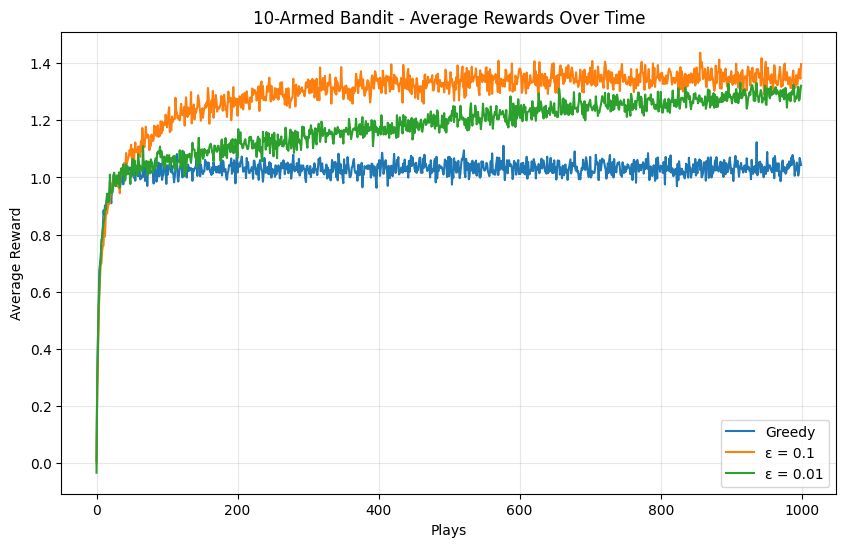

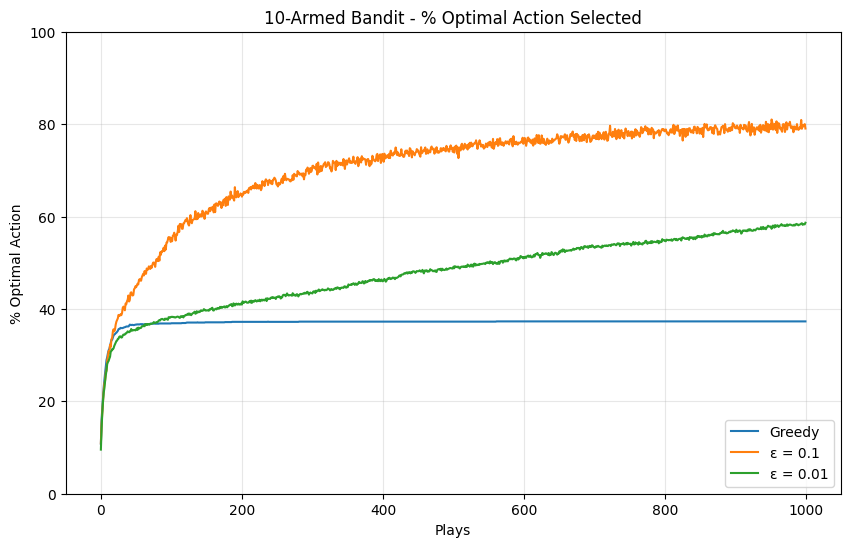

In [5]:
if __name__ == "__main__":
    # Configuration
    nArms = 10
    iterations = 2000
    plays = 1000
    
    # Initialize environment with three agents using different epsilon values
    testbed = Testbed(nArms=nArms, mean=0, stDev=1)
    agents = [
        Agent(nArms=nArms),           # Greedy (ε=0)
        Agent(nArms=nArms, eProb=0.1), # ε=0.1
        Agent(nArms=nArms, eProb=0.01) # ε=0.01
    ]
    environment = Environment(testbed=testbed, agents=agents, plays=plays, iterations=iterations)

    # Run experiment
    print("Running 10-Armed Bandit simulation...")
    start_time = time.time()
    g1Scores, g2Optimal = environment.play()
    elapsed_time = time.time() - start_time
    print(f"Execution time: {elapsed_time:.2f} seconds")

    # Plot 1: Average Rewards
    plt.figure(figsize=(10, 6))
    plt.title("10-Armed Bandit - Average Rewards Over Time")
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot 2: Optimal Action Selection
    plt.figure(figsize=(10, 6))
    plt.title("10-Armed Bandit - % Optimal Action Selected")
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.grid(True, alpha=0.3)
    plt.show()